In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Data Loading
Load the dataset which has been processed by data-cleaning-and-transofrmation.ipynb

In [38]:
# Load the dataset
file_path = './data/processed/marketing_campaign_transformed.csv'
df_transformed = pd.read_csv(file_path, sep=',')

# Correlation Analysis and Feature Selection
Remove Highly Correlated Features to prevent skew clustering results by giving too much weight to some features

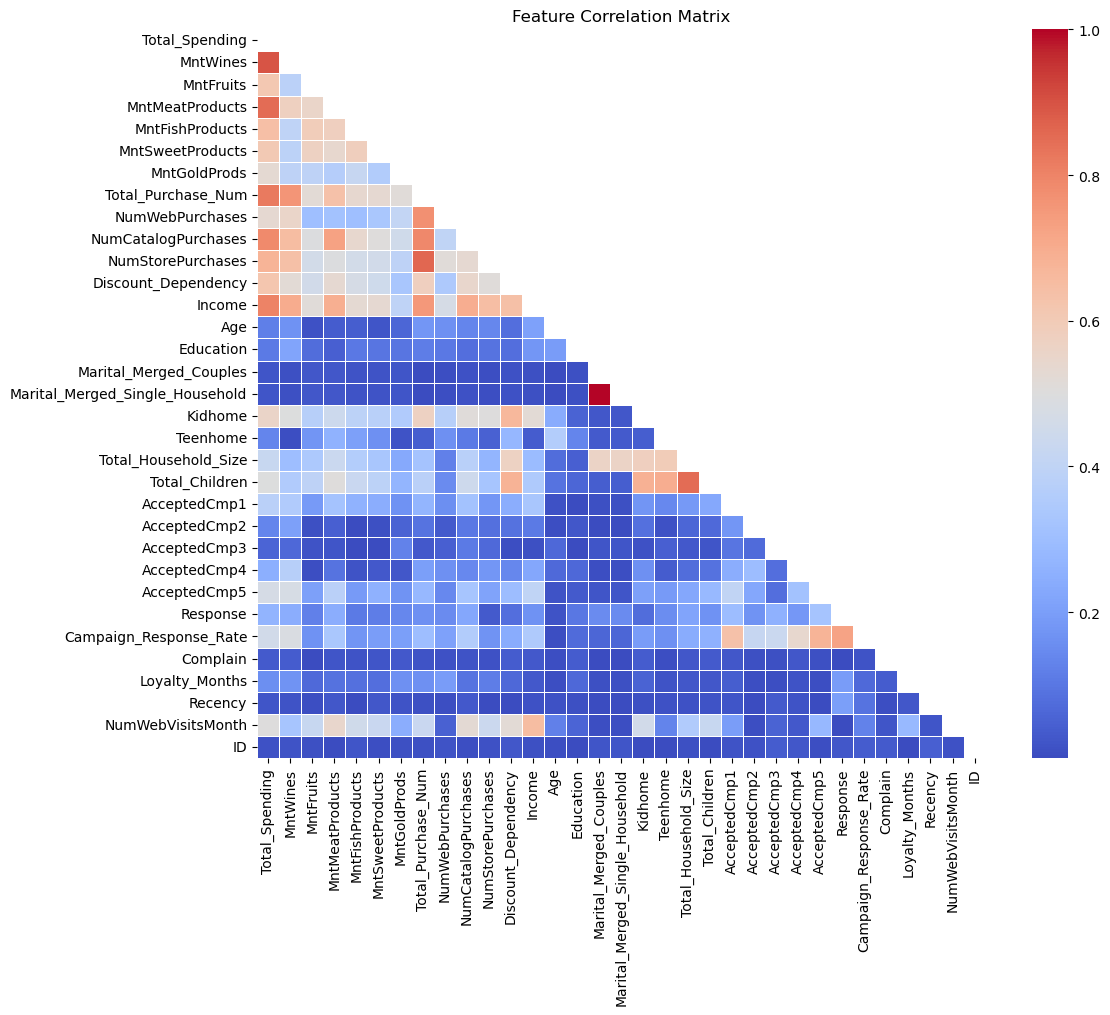

In [39]:
# Calculate correlation matrix 
corr_matrix = df_transformed.corr().abs()

# Visualize correlations
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', 
            annot=False, square=True, linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [40]:
high_corr_features=['MntWines', 'MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','Kidhome', 'Teenhome','Total_Children','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response']

df_filtered = df_transformed.drop(columns=high_corr_features)
print(f"Original shape: {df_transformed.shape}, New shape: {df_filtered.shape}")

Original shape: (2204, 33), New shape: (2204, 15)


# Split the training and testing data set
 - Spilt the training and testing data set before scaling the training data to avoid data leakage

 - Training set: Used to build the clustering model and identify the cluster centers.
 - Test set: Used to:
   - Evaluate how well new data fits into the existing clusters
   - Test the stability of the clusters

In [41]:
# Split before transformation
X_train, X_test = train_test_split(df_filtered, test_size=0.2, random_state=42)

# Before scaling, keep a copy of the ID columns
X_train_ids = X_train['ID'].copy()
X_test_ids = X_test['ID'].copy()

# Remove ID from features used for clustering
X_train = X_train.drop(columns=['ID'])
X_test = X_test.drop(columns=['ID'])

# Scale/Normalize features for the training data

In [42]:
# Ensure columns_to_exclude is defined
columns_to_exclude = ['Response','Marital_Merged_Single_Household','Marital_Merged_Couples', 
                       'Marital_Status_Grouped', 'Complain' ]

# Ensure numerical_columns is defined
numerical_columns = X_train.select_dtypes(include=['number']).columns
columns_to_scale = [col for col in numerical_columns if col not in columns_to_exclude]

# Initialize scaler
scaler = StandardScaler()

# Scale numerical features
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

# Print summary of scaled features
print("Scaled Features Summary:")
print(X_train_scaled[columns_to_scale].describe().round(2))

# Verify scaling worked as expected (should see mean ≈ 0 and std ≈ 1)
print("\nVerification of scaling:")
print("Means:", X_train_scaled[columns_to_scale].mean().abs().mean().round(4))
print("Standard deviations:", X_train_scaled[columns_to_scale].std().mean().round(4))

# Save scaled version
X_train_scaled.to_csv('./data/processed/DBSCAN/marketing_campaign_scaled_dbscan.csv', index=False)

Scaled Features Summary:
       Total_Spending  Total_Purchase_Num  Discount_Dependency   Income  \
count         1763.00             1763.00              1763.00  1763.00   
mean             0.00               -0.00                 0.00     0.00   
std              1.00                1.00                 1.00     1.00   
min             -1.02               -1.77                -1.38    -2.37   
25%             -0.91               -0.93                -0.91    -0.77   
50%             -0.34                0.04                -0.21    -0.00   
75%              0.74                0.87                 0.57     0.78   
max              3.18                2.68                 3.37     4.97   

           Age  Education  Total_Household_Size  Campaign_Response_Rate  \
count  1763.00    1763.00               1763.00                 1763.00   
mean     -0.00       0.00                 -0.00                    0.00   
std       1.00       1.00                  1.00                    1.00   

# DBSCAN Clustering
Key Steps: 
1. Finding Optimal Epsilon
2. Fit the DBSCAN Model
3. Calculate silhouette score and Davies Bouldin score to evaluate model
4. Calculate cluster distribution
6. Evaulate model stability 

### 1. Finding Optimal Epsilon

Use the elbow method on k-distance plot to find the optimal eps.

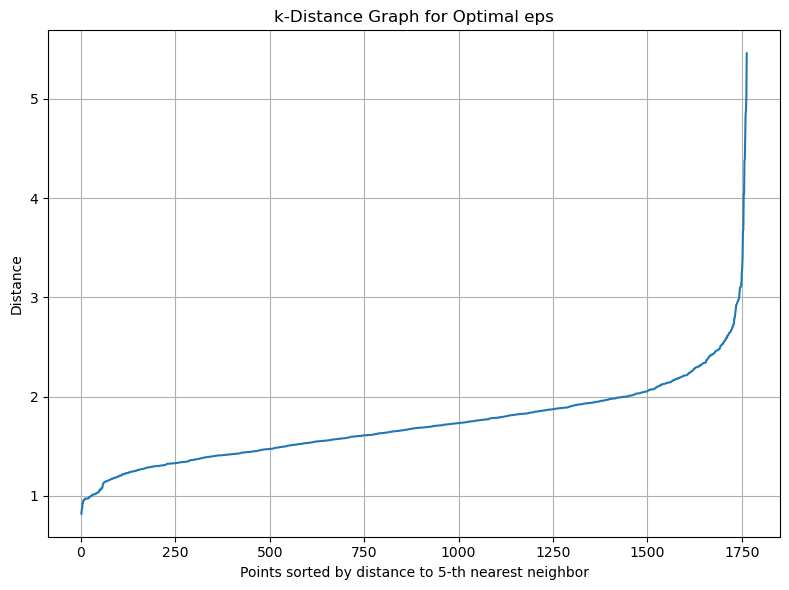

In [43]:
# Calculate the distance to the k nearest neighbor
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_train_scaled)
distances, indices = neighbors.kneighbors(X_train_scaled)

# Sort the distances in ascending order
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(distances)+1), distances)
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
plt.ylabel('Distance')
plt.title('k-Distance Graph for Optimal eps')
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Fit the DBSCAN Model

Apply and fit DBSCAN on the scaled training data and determine number of clusters.

In [44]:
# Set optimal DBSCAN parameters
op_eps = 2  # using elbow method
op_min_samples = 3  # trial and error - 2 produced too many clusters, 4 produced only 2 clusters

# Apply DBSCAN on the scaled training data
dbscan = DBSCAN(eps=op_eps, min_samples=op_min_samples)
cluster_labels = dbscan.fit_predict(X_train_scaled)

# Store the cluster labels and print the number of clusters found
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters (excluding noise): {num_clusters}")

# Remove noise points
valid_clusters = cluster_labels != -1


Number of clusters (excluding noise): 4


### 3. Calculate Silhouette Score and Davies-Bouldin Score to Evaluate Model

Calculate the Silhouette score and Davies-Bouldin score to evaluate model and compare to alternative clustering methods.

In [ ]:
# Calculate silhouette score (the higher the better)
if valid_clusters.sum() > 1:
    sil_score = silhouette_score(X_train_scaled[valid_clusters], cluster_labels[valid_clusters])
else:
    sil_score = -1

# Calculate Davies-Bouldin score (the lower the better)
db_score = davies_bouldin_score(X_train_scaled[valid_clusters], cluster_labels[valid_clusters])

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Score: {db_score:.4f}")

Silhouette Score: -0.0343
Davies-Bouldin Score: 1.2285


### 4. Calculate Cluster Distribution

Calculate the cluster distribution and percentage distribution to take a closer look at the results. Save the cluster data in a csv file.

In [46]:
# Add the cluster labels to the dataframe
X_train_with_result = X_train.copy()
X_train_with_result['Cluster'] = cluster_labels

# Calculate cluster distribution
cluster_distribution = X_train_with_result["Cluster"].value_counts().sort_index()

# Calculate percentage distribution
cluster_percentage = (cluster_distribution / len(X_train_with_result)) * 100

# Print cluster distribution
print("\nCluster Distribution (Absolute):")
print(cluster_distribution)

print("\nCluster Distribution (Percentage):")
print(cluster_percentage)

# Save the clustered data
X_train_with_result.to_csv("./data/processed/DBSCAN/clustered_data_dbscan.csv", index=False)
print("✅ Clustering complete! Results saved to clustered_data_dbscan.csv.")



Cluster Distribution (Absolute):
Cluster
-1     121
 0    1633
 1       3
 2       3
 3       3
Name: count, dtype: int64

Cluster Distribution (Percentage):
Cluster
-1     6.863301
 0    92.626205
 1     0.170164
 2     0.170164
 3     0.170164
Name: count, dtype: float64
✅ Clustering complete! Results saved to clustered_data_dbscan.csv.


### 5. Evaulate model stability

Calculate model stability. 

In [47]:
# Merge cluster results with original data
train_results = pd.DataFrame({'ID': X_train_ids, 'Cluster': cluster_labels})

# Apply fit_predict to the training data
test_clusters = dbscan.fit_predict(X_test_scaled)

test_results = pd.DataFrame({'ID': X_test_ids, 'Cluster': test_clusters})
combined_clusters = pd.concat([train_results, test_results], axis=0)

df_with_clusters = pd.merge(
    df_transformed,
    combined_clusters,
    on='ID',
    how='left'
)
df_with_clusters.to_csv('./data/processed/DBSCAN/marketing_campaign_transformed_with_clusters_dbscan.csv', index=False)

# Evaluate model stability
train_dist = X_train_with_result['Cluster'].value_counts(normalize=True)
test_dist = test_results['Cluster'].value_counts(normalize=True)
print("\nCluster distribution comparison:")
print(pd.DataFrame({'Train': train_dist, 'Test': test_dist}))


Cluster distribution comparison:
            Train      Test
Cluster                    
-1       0.068633  0.224490
 0       0.926262  0.761905
 1       0.001702  0.006803
 2       0.001702  0.006803
 3       0.001702       NaN


# Key Takeaways from Model

Overall, a DBSCAN clustering model did not seem like to right choice for this dataset. When we were selecting the two clustering methods to test out, we predited that the k-means clustering model was the better fit, however we wanted to test out two different approaches.

#### **Silhouette Score Comparison**

**k-means silhouette score:** 0.1248

**DBSCAN silhouette score:** -0.0343

Our k-means model had a higher silhouette score, which indicates better model performance.

#### **Davies-Bouldin Score Comparison**

**k-means Davies-Bouldin score:** 2.2083

**DBSCAN Davies-Bouldin score:** 1.2285

Our DBSCAN model had a lower Davies-Bouldin score, which indicates better model performance.

#### **Cluster Distribution**

The largest indicator of our DBSCAN model not being the right fit for this dataset was the large number of noise points and the uneven dispersement of datapoints across the clusters. As you can see below, there were 1633 datapoints in Cluster 0 and only 3 in the remaining clustors. This indicated that this model was not going to give us the necessary insights we needed for our business case.


Cluster Distribution (Absolute):
Cluster | # of datapoints
--- | --- 
-1 | 121 
0 | 1633 
1 | 3
2 | 3
3 | 3